In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import pickle
import json
import torch
from tqdm import tqdm, tqdm_notebook

from performance import *
from pycit import *
from bullseye import bullseye_network, get_ci_dict
from mapping import ModelManager

# matplotlib and seaborn settings
from matplotlib import rc
rc('text', usetex=True)
plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

sns.set_style("white")

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 14}

# plt.legend(prop={'family':'serif', 'size': 12}, loc=4)

In [4]:
# make data
num_samples = 5000 
dim = 3
r_data, x_data, y_data = bullseye_network(num_samples, dim, eps=0.075)
r_data = standardize(r_data.astype(np.float16))
x_data = standardize(x_data.astype(np.float16))
y_data = standardize(y_data.astype(np.float16))

np.save("data/bullseye_3d_performance_r_data.npy", r_data)
np.save("data/bullseye_3d_performance_y_data.npy", y_data)
np.save("data/bullseye_3d_performance_x_data.npy", x_data)

    epoch          : 1
    loss           : 10.212163753509522
Saving current best: model_best.pth ...
    epoch          : 2
    loss           : 9.0878937625885
Saving current best: model_best.pth ...
    epoch          : 3
    loss           : 8.833099431991577
Saving current best: model_best.pth ...
    epoch          : 4
    loss           : 8.749506731033325
Saving current best: model_best.pth ...
    epoch          : 5
    loss           : 8.656467266082764
Saving current best: model_best.pth ...
    epoch          : 6
    loss           : 8.54917350769043
Saving current best: model_best.pth ...
    epoch          : 7
    loss           : 8.486200246810913
Saving current best: model_best.pth ...
    epoch          : 8
    loss           : 8.382093534469604
Saving current best: model_best.pth ...
    epoch          : 9
    loss           : 8.316939525604248
Saving current best: model_best.pth ...
    epoch          : 10
    loss           : 8.203296747207641
Saving current best: 

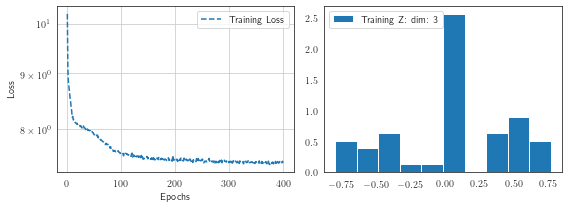

In [5]:
config_path = "config/experiment_3d_bullseye_regularized.json"
manager = ModelManager(config_path, make_plots=True)
manager.train()

In [6]:
manager.load_model(checkpoint_file="model_best.pth")
mu,lv,z = manager.process_numpy(x_data)
z_data = standardize(z)

In [7]:
citest(z_data[:,:,3], y_data, z_data[:,:,(2,4,5)], statistic='ksg_cmi', statistic_args={'k':5}, test_args={'k_perm': 10, 'n_trials': 250, 'n_jobs': 4})

0.272

In [6]:
# set settings
CONFIDENCE_LEVEL = 0.95
K_KNN = 5
K_PERM = 5
SUBSAMPLE_SIZE = None
N_TRIALS = 250
N_JOBS = 4

cit_funcs = {
    'it_args': {
        'statistic_args': {
            'k': K_KNN
        },
        'test_args': {
            'statistic': 'mixed_mi',
            'k_perm': K_PERM,
            'subsample_size': SUBSAMPLE_SIZE,
            'n_trials': N_TRIALS,
            'n_jobs': N_JOBS
        }
    },
    'cit_args': {
        'statistic_args': {
            'k': K_KNN
        },
        'test_args': {
            'statistic': 'mixed_cmi',
            'k_perm': K_PERM,
            'subsample_size': SUBSAMPLE_SIZE,
            'n_trials': N_TRIALS,
            'n_jobs': N_JOBS
        }
    }
}

# find Markov blanket
mb = MarkovBlanket(z_data, y_data, cit_funcs)
selected = mb.find_markov_blanket(min_conditioning=2, confidence=CONFIDENCE_LEVEL, verbose=True)

==========Finding Adjacents...==========
Testing X_{2}
  Cond. set: ['X_{3}', 'X_{6}']
    Is CI: False, pval: 0.000
  Cond. set: ['X_{4}', 'X_{6}']
    Is CI: False, pval: 0.000
  Cond. set: ['X_{3}', 'X_{4}']
    Is CI: False, pval: 0.000
  Cond. set: ['X_{1}', 'X_{5}']
    Is CI: True, pval: 0.260
Testing X_{3}
  Cond. set: ['X_{5}', 'X_{6}']
    Is CI: False, pval: 0.000
  Cond. set: ['X_{4}', 'X_{6}']
    Is CI: False, pval: 0.000
  Cond. set: ['X_{1}', 'X_{4}']
    Is CI: False, pval: 0.000
  Cond. set: ['X_{1}', 'X_{6}']
    Is CI: False, pval: 0.000
  Cond. set: ['X_{4}', 'X_{5}']
    Is CI: False, pval: 0.000
  Cond. set: ['X_{1}', 'X_{5}']
    Is CI: False, pval: 0.000
Testing X_{4}
  Cond. set: ['X_{3}', 'X_{6}']
    Is CI: True, pval: 0.116
Testing X_{6}
  Cond. set: ['X_{3}', 'X_{5}']
    Is CI: False, pval: 0.000
  Cond. set: ['X_{1}', 'X_{5}']
    Is CI: False, pval: 0.000
  Cond. set: ['X_{1}', 'X_{3}']
    Is CI: False, pval: 0.000
Testing X_{5}
  Cond. set: ['X_{1}', 

In [7]:
np.save("data/bullseye_4d_performance_z_data.npy", z_data)

In [8]:
ci_dict = get_ci_dict()

# knn settings
statistic_args = {
    'k': 5
}
test_args={
    'k_perm': 10,
    'n_trials': 250,
    'knn_jobs': 11,
    'n_jobs': 4
}

# perform cits
pred_prop, true_prop = [], []
for i in range(6):
    for size in range(1,5):
        for cond_set in combinations([k for k in range(6) if k != i], size):
            # true ci relation
            ground_truth = 0
            if i in ci_dict:
                if set(cond_set) in ci_dict[i]:
                    ground_truth = 1

            print("is CI: %r, var: %d, cond_set: %s"%(bool(ground_truth), i, str(cond_set)))

            # knn method
            pval_prop = citest(z_data[:,:,i], y_data, z_data[:,:,cond_set], statistic='ksg_cmi', statistic_args=statistic_args, test_args=test_args)
            pred_prop.append(pval_prop)
            true_prop.append(ground_truth)
            print ("  knn pval: %0.3f"%pval_prop)

performance_prop = np.stack((pred_prop, true_prop))
np.save("data/bullseye_4d_performance_prop.npy", performance_prop)

is CI: False, var: 0, cond_set: (1,)
  knn pval: 0.000
is CI: False, var: 0, cond_set: (2,)
  knn pval: 0.000
is CI: False, var: 0, cond_set: (3,)
  knn pval: 0.000
is CI: False, var: 0, cond_set: (4,)
  knn pval: 0.000
is CI: False, var: 0, cond_set: (5,)
  knn pval: 0.000
is CI: True, var: 0, cond_set: (1, 2)
  knn pval: 0.208
is CI: False, var: 0, cond_set: (1, 3)
  knn pval: 0.000
is CI: False, var: 0, cond_set: (1, 4)
  knn pval: 0.000
is CI: False, var: 0, cond_set: (1, 5)
  knn pval: 0.000
is CI: False, var: 0, cond_set: (2, 3)
  knn pval: 0.000
is CI: True, var: 0, cond_set: (2, 4)
  knn pval: 0.012
is CI: False, var: 0, cond_set: (2, 5)
  knn pval: 0.000
is CI: False, var: 0, cond_set: (3, 4)
  knn pval: 0.000
is CI: False, var: 0, cond_set: (3, 5)
  knn pval: 0.000
is CI: False, var: 0, cond_set: (4, 5)
  knn pval: 0.000
is CI: True, var: 0, cond_set: (1, 2, 3)
  knn pval: 0.036
is CI: True, var: 0, cond_set: (1, 2, 4)
  knn pval: 0.148
is CI: True, var: 0, cond_set: (1, 2, 5

AUC knn proposed: 0.8979748979749063


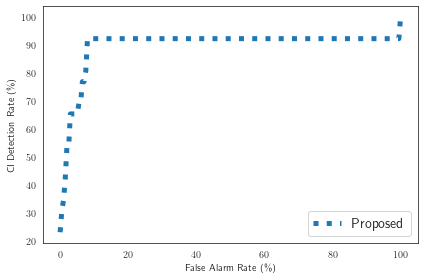

In [9]:
performance_prop = np.load("data/bullseye_4d_performance_prop.npy")

eps = 1e-4
fars = np.linspace(0., 1., 200)
drs_prop = np.zeros(fars.shape)
for i,far in enumerate(fars):
    drs_prop[i] = detection_atper(np.clip(performance_prop[0], eps, 1-eps), performance_prop[1], target_far=far)

print ("AUC knn proposed:", area_under_roc(performance_prop[0], performance_prop[1]))

plt.figure(figsize=(6,4))
plt.plot(fars*100, drs_prop*100, ':', lw=5, label="Proposed")
plt.ylabel("CI Detection Rate (\%)")
plt.xlabel("False Alarm Rate (\%)")
plt.legend(prop={'family':'serif', 'size': 14}, loc=4)
plt.tight_layout()
plt.show()

AUC knn: 0.8818433818433924
AUC knn proposed: 0.8979748979749063
AUC sdcit: 0.8804188804188838


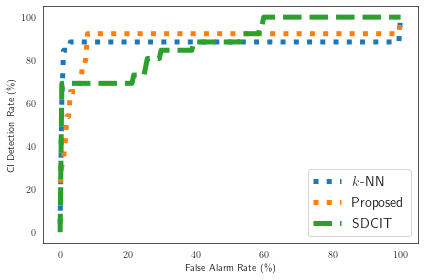

In [4]:
# performance_sdcit = np.load("data/bullseye_4d_performance_sdcit.npy")
# performance_knn = np.load("data/bullseye_4d_performance_knn.npy")
# performance_prop = np.load("data/bullseye_4d_performance_prop.npy")
# # performance_ccit = np.load("data/bullseye_4d_performance_ccit.npy")

# eps = 1e-4
# fars = np.linspace(0., 1., 200)
# drs_knn = np.zeros(fars.shape)
# drs_prop = np.zeros(fars.shape)
# drs_ccit = np.zeros(fars.shape)
# drs_sdcit = np.zeros(fars.shape)
# for i,far in enumerate(fars):
#     drs_knn[i] = detection_atper(np.clip(performance_knn[0], eps, 1-eps), performance_knn[1], target_far=far)
#     drs_prop[i] = detection_atper(np.clip(performance_prop[0], eps, 1-eps), performance_prop[1], target_far=far)
#     # drs_ccit[i] = detection_atper(np.clip(performance_ccit[0], eps, 1-eps), performance_ccit[1], target_far=far)
#     drs_sdcit[i] = detection_atper(np.clip(performance_sdcit[0], eps, 1-eps), performance_sdcit[1], target_far=far)

# print ("AUC knn:", area_under_roc(performance_knn[0], performance_knn[1]))
# print ("AUC knn proposed:", area_under_roc(performance_prop[0], performance_prop[1]))
# # print ("AUC ccit:", area_under_roc(performance_ccit[0], performance_ccit[1]))
# print ("AUC sdcit:", area_under_roc(performance_sdcit[0], performance_sdcit[1]))

# plt.figure(figsize=(6,4))
# plt.plot(fars*100, drs_knn*100, ':', lw=5, label="$k$-NN")
# plt.plot(fars*100, drs_prop*100, ':', lw=5, label="Proposed")
# plt.plot(fars*100, drs_sdcit*100, '--', lw=5, label="SDCIT")
# # plt.plot(fars*100, drs_ccit*100, '-.', lw=5, label="CCIT")
# plt.ylabel("CI Detection Rate (\%)")
# plt.xlabel("False Alarm Rate (\%)")
# plt.legend(prop={'family':'serif', 'size': 14}, loc=4)
# plt.tight_layout()
# plt.show()